In [7]:
import kagglehub

path = kagglehub.dataset_download("andrewmvd/animal-faces")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animal-faces


In [8]:
!cp -r /kaggle/input/animal-faces/ /content/animal_faces

In [4]:
!rm -rf /content/animal_faces/

In [9]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import torch
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
image_path = []
labels = []

for i in os.listdir("/content/animal_faces/afhq"):
  for label in os.listdir(f"/content/animal_faces/afhq/{i}"):
    for image in os.listdir(f"/content/animal_faces/afhq/{i}/{label}"):
      image_path.append(f"/content/animal_faces/afhq/{i}/{label}/{image}")
      labels.append(label)

data_df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "label"])

label_encoder = LabelEncoder()
data_df["encoded_label"] = label_encoder.fit_transform(data_df["label"])

from sklearn.model_selection import train_test_split
train, val = train_test_split(data_df, test_size=0.2, stratify=data_df["encoded_label"], random_state=42)
test, val = train_test_split(val, test_size=0.5, stratify=val["encoded_label"], random_state=42)


In [11]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [12]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]["image_path"]
        label = self.dataframe.iloc[index]["encoded_label"]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [13]:
train_dataset = CustomImageDataset(train, transform=transform)
val_dataset = CustomImageDataset(val, transform=transform)
test_dataset = CustomImageDataset(test, transform=transform)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [14]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

class Network(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.adapt = nn.AdaptiveAvgPool2d((4, 4))
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.pool3(self.relu(self.conv3(x)))
        x = self.adapt(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

model = Network(num_classes=len(label_encoder.classes_)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [15]:
EPOCHS = 10
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_loss_val = 0
    total_acc_val = 0

    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()
        train_loss.backward()
        optimizer.step()

        total_acc_train += (outputs.argmax(1) == labels).sum().item()

    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()
            total_acc_val += (outputs.argmax(1) == labels).sum().item()

    total_loss_train_plot.append(round(total_loss_train / len(train_loader), 4))
    total_loss_val_plot.append(round(total_loss_val / len(val_loader), 4))
    total_acc_train_plot.append(round((total_acc_train / len(train_dataset)) * 100, 2))
    total_acc_val_plot.append(round((total_acc_val / len(val_dataset)) * 100, 2))

    print(f'''
    EPOCH {epoch+1}/{EPOCHS}
    Train Loss     : {total_loss_train_plot[-1]}
    Train Accuracy : {total_acc_train_plot[-1]}%
    Val Loss       : {total_loss_val_plot[-1]}
    Val Accuracy   : {total_acc_val_plot[-1]}%
    ''')


    EPOCH 1/10
    Train Loss     : 0.5608
    Train Accuracy : 75.55%
    Val Loss       : 0.2794
    Val Accuracy   : 89.27%
    

    EPOCH 2/10
    Train Loss     : 0.2092
    Train Accuracy : 91.94%
    Val Loss       : 0.1515
    Val Accuracy   : 94.48%
    

    EPOCH 3/10
    Train Loss     : 0.1373
    Train Accuracy : 95.13%
    Val Loss       : 0.1265
    Val Accuracy   : 95.72%
    

    EPOCH 4/10
    Train Loss     : 0.1067
    Train Accuracy : 96.1%
    Val Loss       : 0.1657
    Val Accuracy   : 94.42%
    

    EPOCH 5/10
    Train Loss     : 0.0869
    Train Accuracy : 96.82%
    Val Loss       : 0.1196
    Val Accuracy   : 96.09%
    

    EPOCH 6/10
    Train Loss     : 0.0698
    Train Accuracy : 97.66%
    Val Loss       : 0.1135
    Val Accuracy   : 96.96%
    

    EPOCH 7/10
    Train Loss     : 0.0572
    Train Accuracy : 97.93%
    Val Loss       : 0.1211
    Val Accuracy   : 96.16%
    

    EPOCH 8/10
    Train Loss     : 0.0495
    Train Accuracy : 98.2%

In [16]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    predictions = model(inputs)

    acc = (predictions.argmax(1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

  print(f'''Accuracy Score is : {round((total_acc_test/test_dataset.__len__()*100),4)}
            Loss is : {round(total_loss_test/1000,4)}
        ''')

Accuracy Score is : 97.4582
            Loss is : 0.0088
        


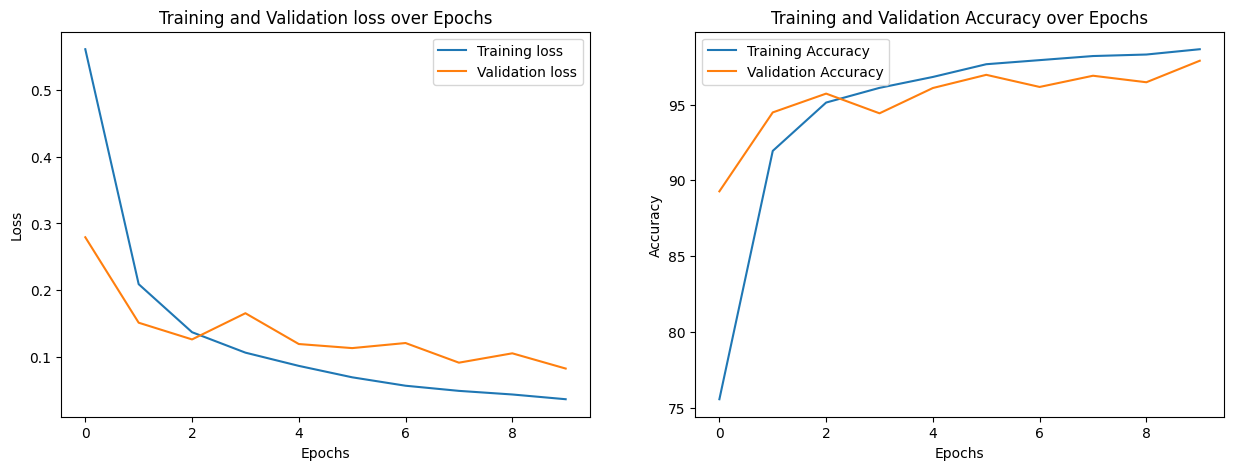

In [17]:
fig, axs = plt.subplots(nrows = 1, ncols=2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label= "Training loss")
axs[0].plot(total_loss_val_plot, label= "Validation loss")
axs[0].set_title("Training and Validation loss over Epochs")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label= "Training Accuracy")
axs[1].plot(total_acc_val_plot, label= "Validation Accuracy")
axs[1].set_title("Training and Validation Accuracy over Epochs")
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


plt.show()

In [18]:
def predict_image(model, image_path, transform, label_encoder, device):
    model.eval()

    # Load and transform image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(image)
        predicted_class = output.argmax(dim=1).item()

    # Decode label
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    return predicted_label


In [ ]:
img_path = "/content/horse_2.jpg"
predicted = predict_image(model, img_path, transform, label_encoder, device)
print("Predicted:", predicted)


Predicted: wild


In [20]:
from torchsummary import summary

In [21]:
summary(model=model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
              ReLU-5           [-1, 64, 64, 64]               0
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
              ReLU-8          [-1, 128, 32, 32]               0
         MaxPool2d-9          [-1, 128, 16, 16]               0
AdaptiveAvgPool2d-10            [-1, 128, 4, 4]               0
           Linear-11                  [-1, 256]         524,544
             ReLU-12                  [-1, 256]               0
           Linear-13                    [-1, 3]             771
Total params: 618,563
Trainable params:

2025-08-22 07:03:31.666 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-22 07:03:31.709 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-08-22 07:03:31.709 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-22 07:03:31.710 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-22 07:03:31.711 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-22 07:03:31.712 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-22 07:03:31.713 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-22 07:03:31.714 Thread 'MainThread': mi

In [2]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 120.2 MB/s eta 0:00:00


In [22]:
import torch
import pickle

# Define the path to save the model
model_path = "animal_face_classifier.pkl"

# Save the model
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to animal_face_classifier.pkl
